In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import logging

import spacy
from spacy.util import minibatch
from spacy import displacy

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.probability import FreqDist

import networkx as nx

from gensim.corpora import Dictionary
from gensim.models import LdaModel, TfidfModel, CoherenceModel
from gensim.matutils import corpus2dense


In [ ]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
data = pd.read_csv("/content/Source_Breach_Report.csv")
data.head()

,Name of Covered Entity,State,Covered Entity Type,Individuals Affected,Breach Submission Date,Type of Breach,Location of Breached Information,Business Associate Present,Web Description
0,Bay Oral Surgery & Implant Center,WI,Healthcare Provider,13055.0,04/26/2024,Hacking/IT Incident,Email,No,"The covered entity (CE), Bay Oral Surgery & Im..."
1,MHNU Corporation d/b/a Medical Home Network,IL,Business Associate,681.0,04/16/2024,Hacking/IT Incident,Email,Yes,"The business associate (BA), MHNU Corporation ..."
2,California Correctional Health Care Services,CA,Healthcare Provider,1348.0,03/14/2024,Unauthorized Access/Disclosure,Email,No,"The covered entity (CE), California Correction..."
3,Massachusetts Department of Developmental Serv...,MA,Healthcare Provider,500.0,03/11/2024,Improper Disposal,Paper/Films,No,"The covered entity (CE), Massachusetts Departm..."
4,Orlando VA Medical Center,FL,Healthcare Provider,9850.0,03/05/2024,Unauthorized Access/Disclosure,Email,No,"The Orlando VA Medical Center, the covered ent..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5371 entries, 0 to 5370
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Name of Covered Entity            5371 non-null   object 
 1   State                             5358 non-null   object 
 2   Covered Entity Type               5366 non-null   object 
 3   Individuals Affected              5370 non-null   float64
 4   Breach Submission Date            5371 non-null   object 
 5   Type of Breach                    5370 non-null   object 
 6   Location of Breached Information  5371 non-null   object 
 7   Business Associate Present        5371 non-null   object 
 8   Web Description                   5065 non-null   object 
dtypes: float64(1), object(8)
memory usage: 377.8+ KB


# Handling column name inconsistency

In [ ]:
# Handling column name inconsistency
def standardize_columns(df):
    # Replace spaces with underscores and convert to lowercase
    df.columns = df.columns.str.replace(" ","_")
    df.columns = df.columns.str.replace("-","_").str.lower()
    return df

data = standardize_columns(data)
data.head()

,name_of_covered_entity,state,covered_entity_type,individuals_affected,breach_submission_date,type_of_breach,location_of_breached_information,business_associate_present,web_description
0,Bay Oral Surgery & Implant Center,WI,Healthcare Provider,13055.0,04/26/2024,Hacking/IT Incident,Email,No,"The covered entity (CE), Bay Oral Surgery & Im..."
1,MHNU Corporation d/b/a Medical Home Network,IL,Business Associate,681.0,04/16/2024,Hacking/IT Incident,Email,Yes,"The business associate (BA), MHNU Corporation ..."
2,California Correctional Health Care Services,CA,Healthcare Provider,1348.0,03/14/2024,Unauthorized Access/Disclosure,Email,No,"The covered entity (CE), California Correction..."
3,Massachusetts Department of Developmental Serv...,MA,Healthcare Provider,500.0,03/11/2024,Improper Disposal,Paper/Films,No,"The covered entity (CE), Massachusetts Departm..."
4,Orlando VA Medical Center,FL,Healthcare Provider,9850.0,03/05/2024,Unauthorized Access/Disclosure,Email,No,"The Orlando VA Medical Center, the covered ent..."


In [ ]:
# Define the phrases to remove
phrases_to_remove = ["The business associate (BA)", "The covered entity (CE)"]

# Replace the phrases with an empty string
for phrase in phrases_to_remove:
    data['web_description'] = data['web_description'].str.replace(phrase, '', regex=False)

data.head()

,name_of_covered_entity,state,covered_entity_type,individuals_affected,breach_submission_date,type_of_breach,location_of_breached_information,business_associate_present,web_description
0,Bay Oral Surgery & Implant Center,WI,Healthcare Provider,13055.0,04/26/2024,Hacking/IT Incident,Email,No,", Bay Oral Surgery & Implant Center, reported ..."
1,MHNU Corporation d/b/a Medical Home Network,IL,Business Associate,681.0,04/16/2024,Hacking/IT Incident,Email,Yes,", MHNU Corporation dba Medical Home Network, r..."
2,California Correctional Health Care Services,CA,Healthcare Provider,1348.0,03/14/2024,Unauthorized Access/Disclosure,Email,No,", California Correctional Health Care Services..."
3,Massachusetts Department of Developmental Serv...,MA,Healthcare Provider,500.0,03/11/2024,Improper Disposal,Paper/Films,No,", Massachusetts Department of Developmental Se..."
4,Orlando VA Medical Center,FL,Healthcare Provider,9850.0,03/05/2024,Unauthorized Access/Disclosure,Email,No,"The Orlando VA Medical Center, the covered ent..."


# Data type conversion

In [ ]:
# Convert 'breach_submission_date' column to datetime
data['breach_submission_date'] = pd.to_datetime(data['breach_submission_date'], errors='coerce')

# Ensure other text fields are of type string
data['name_of_covered_entity'] = data['name_of_covered_entity'].astype(str)
data['type_of_breach'] = data['type_of_breach'].astype(str)
data['state'] = data['state'].astype(str)
data['web_description'] = data['web_description'].astype(str)

# Remove duplicates
data.drop_duplicates(inplace=True)

# Handling Missing Values

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5370 entries, 0 to 5370
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   name_of_covered_entity            5370 non-null   object        
 1   state                             5370 non-null   object        
 2   covered_entity_type               5365 non-null   object        
 3   individuals_affected              5369 non-null   float64       
 4   breach_submission_date            5370 non-null   datetime64[ns]
 5   type_of_breach                    5370 non-null   object        
 6   location_of_breached_information  5370 non-null   object        
 7   business_associate_present        5370 non-null   object        
 8   web_description                   5370 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 419.5+ KB


'web_description' has no missing values

In [ ]:
# Proportion of missing values
proportion_of_missing_values = data.isnull().sum().sum() / np.product(data.shape)
proportion_of_missing_values

0.00012414649286157667

In [ ]:
# Define which object columns contain missing values
object_columns = data.select_dtypes(include=["object"]).columns[data.select_dtypes(include='object').isnull().any()]

# Mode imputation
for column in object_columns:
    mode_value = data[column].mode().iloc[0]
    data[column].fillna(mode_value, inplace=True)

# Fill missing 'Individuals Affected' with the mean value
mean_individuals_affected = data['individuals_affected'].mean()
data['individuals_affected'].fillna(mean_individuals_affected, inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5370 entries, 0 to 5370
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   name_of_covered_entity            5370 non-null   object        
 1   state                             5370 non-null   object        
 2   covered_entity_type               5370 non-null   object        
 3   individuals_affected              5370 non-null   float64       
 4   breach_submission_date            5370 non-null   datetime64[ns]
 5   type_of_breach                    5370 non-null   object        
 6   location_of_breached_information  5370 non-null   object        
 7   business_associate_present        5370 non-null   object        
 8   web_description                   5370 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 419.5+ KB


In [ ]:
data.to_csv('cleaned_data.csv', index=False)

# Descriptive analysis

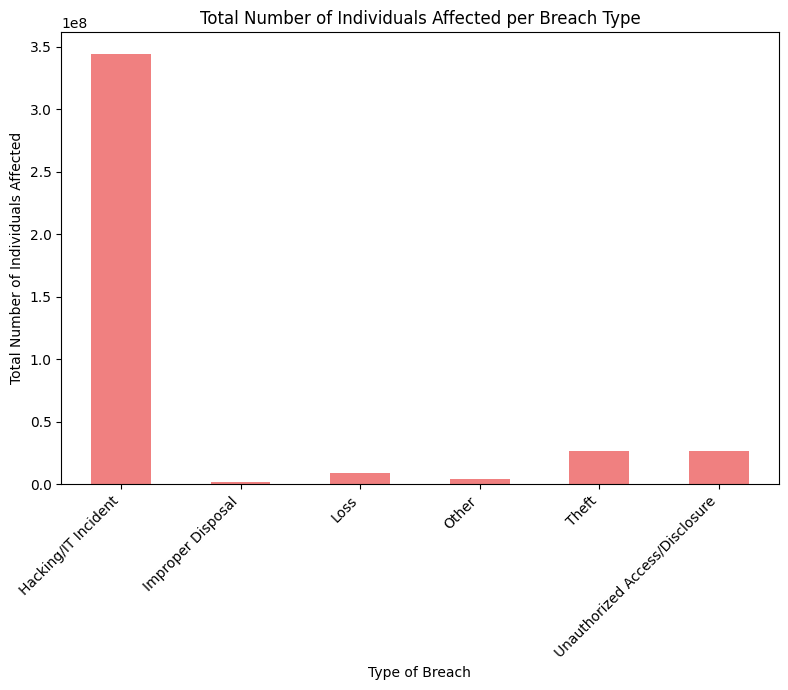

In [ ]:
# Simplifying breach types
data['simplified_type_of_breach'] = data['type_of_breach'].apply(lambda x: x if x in ['Hacking/IT Incident', 'Unauthorized Access/Disclosure', 'Theft', 'Loss', 'Improper Disposal'] else 'Other')

# Filtering the data to include only rows with 'individuals_affected' greater than 0
filtered_data = data[data['individuals_affected'] > 0]

# Calculating the total number of individuals affected per breach type
total_affected_per_breach_type = filtered_data.groupby('simplified_type_of_breach')['individuals_affected'].sum()

# Creating a simple bar chart
plt.figure(figsize=(8, 7))
total_affected_per_breach_type.plot(kind='bar', color='lightcoral')
plt.title('Total Number of Individuals Affected per Breach Type')
plt.xlabel('Type of Breach')
plt.ylabel('Total Number of Individuals Affected')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


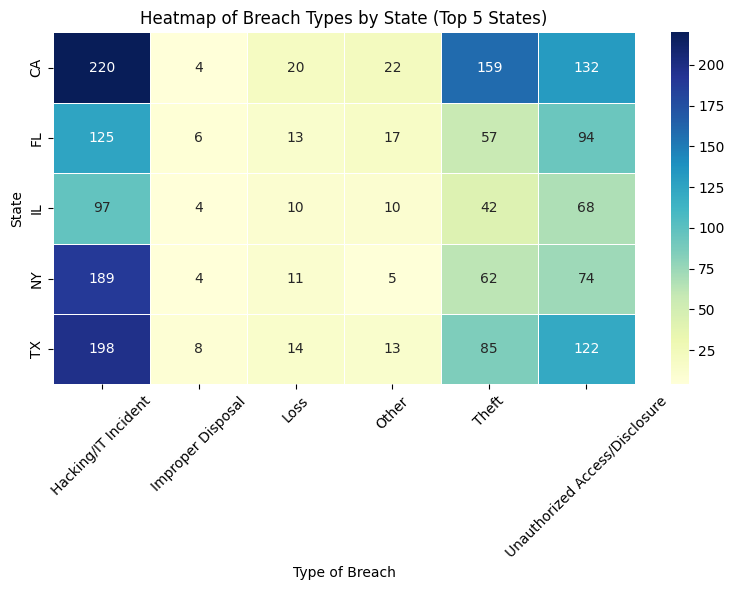

In [ ]:
# Selecting the top 10 states with the most breaches
filtered_data = data[data['individuals_affected'] > 0]
top_5_states = filtered_data['state'].value_counts().head(5).index

# Focusing on significant breach types (most common types)
top_breach_types = filtered_data['simplified_type_of_breach'].value_counts().index

# Preparing the data for the simplified heatmap
simplified_heatmap_data = pd.crosstab(filtered_data[filtered_data['state'].isin(top_5_states)]['state'],
                                      filtered_data['simplified_type_of_breach'])


# Plotting the simplified heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(simplified_heatmap_data, annot=True, fmt='d', cmap='YlGnBu', linewidths=0.7)
plt.title('Heatmap of Breach Types by State (Top 5 States)')
plt.xlabel('Type of Breach')
plt.ylabel('State')

# Rotating the x-axis labels to 45 degrees
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


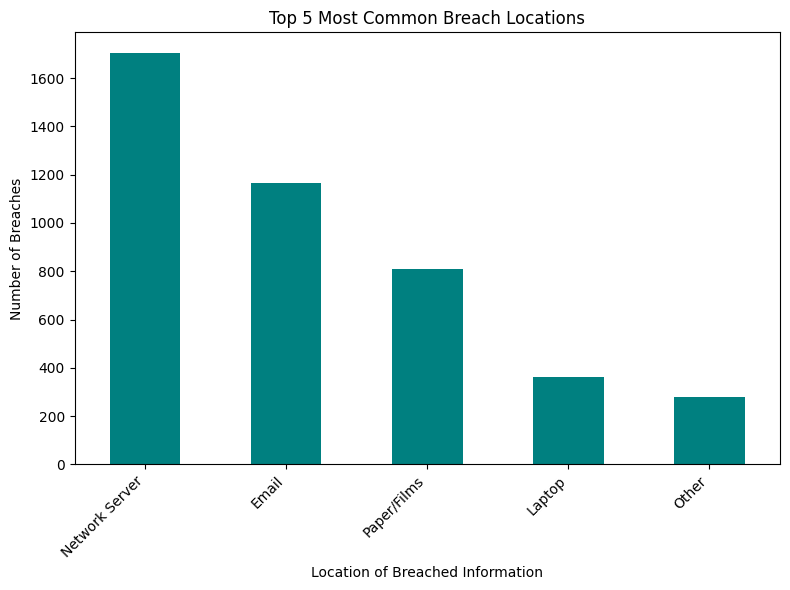

In [ ]:
# Counting the number of breaches in each location and selecting the top 5
top_5_location_counts = filtered_data['location_of_breached_information'].value_counts().head(5)

# Plotting the bar chart for the top 5 breach locations
plt.figure(figsize=(8, 6))
top_5_location_counts.plot(kind='bar', color='teal')
plt.title('Top 5 Most Common Breach Locations')
plt.xlabel('Location of Breached Information')
plt.ylabel('Number of Breaches')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Clean and preprocess the textual data

In [ ]:
# Load SpaCy English model
nlp = spacy.load('en_core_web_sm')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to clean and preprocess text
def preprocess_text(text):
    # Remove non-alphanumeric characters and convert to lowercase
    text = re.sub(r'\W+', ' ', text).lower()
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    # Join tokens back to a single string
    return ' '.join(tokens)

# Clean and preprocess the "web_description" column
data['cleaned_description'] = data['web_description'].astype(str).apply(preprocess_text)
data.head()

,name_of_covered_entity,state,covered_entity_type,individuals_affected,breach_submission_date,type_of_breach,location_of_breached_information,business_associate_present,web_description,simplified_type_of_breach,cleaned_description
0,Bay Oral Surgery & Implant Center,WI,Healthcare Provider,13055.0,2024-04-26,Hacking/IT Incident,Email,No,", Bay Oral Surgery & Implant Center, reported ...",Hacking/IT Incident,bay oral surgery implant center reported emplo...
1,MHNU Corporation d/b/a Medical Home Network,IL,Business Associate,681.0,2024-04-16,Hacking/IT Incident,Email,Yes,", MHNU Corporation dba Medical Home Network, r...",Hacking/IT Incident,mhnu corporation dba medical home network repo...
2,California Correctional Health Care Services,CA,Healthcare Provider,1348.0,2024-03-14,Unauthorized Access/Disclosure,Email,No,", California Correctional Health Care Services...",Unauthorized Access/Disclosure,california correctional health care service re...
3,Massachusetts Department of Developmental Serv...,MA,Healthcare Provider,500.0,2024-03-11,Improper Disposal,Paper/Films,No,", Massachusetts Department of Developmental Se...",Improper Disposal,massachusetts department developmental service...
4,Orlando VA Medical Center,FL,Healthcare Provider,9850.0,2024-03-05,Unauthorized Access/Disclosure,Email,No,"The Orlando VA Medical Center, the covered ent...",Unauthorized Access/Disclosure,orlando va medical center covered entity ce re...


In [ ]:
# Preprocessing: Tokenization
# Tokenize descriptions into words
tokenized_descriptions = []
for description in data["web_description"]:
    tokenized_descriptions.extend(word_tokenize(description))

In [ ]:
def extract_ngrams(text, num):
    tokens = word_tokenize(text.lower())  # Tokenize and lower case
    tokens = [token for token in tokens if token.isalpha() and token not in stopwords.words('english')]  # Remove stopwords and punctuation
    n_grams = ngrams(tokens, num)  # Create n-grams
    return [' '.join(grams) for grams in n_grams]

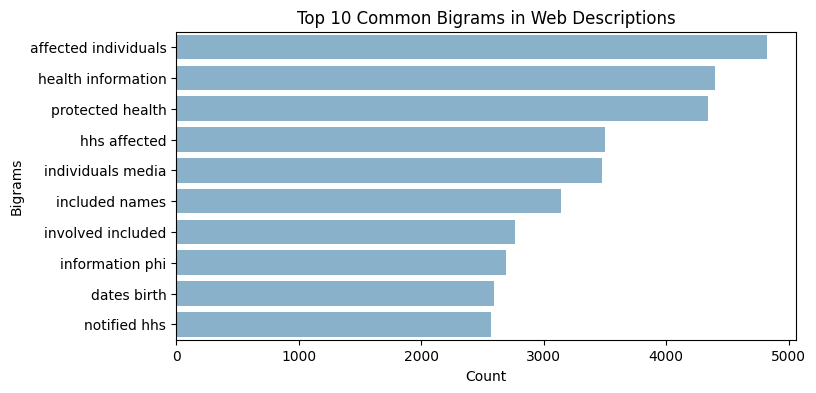

In [ ]:
data['bigrams'] = data['web_description'].apply(lambda x: extract_ngrams(x, 2))
bigrams = [item for sublist in data['bigrams'] for item in sublist]
bigram_freq = FreqDist(bigrams)
df_bigrams = pd.DataFrame(bigram_freq.items(), columns=['phrase', 'count']).sort_values(by='count', ascending=False).head(10)

plt.figure(figsize=(8, 4))
sns.barplot(x='count', y='phrase', data=df_bigrams, color="#7FB3D5")
plt.title('Top 10 Common Bigrams in Web Descriptions')
plt.xlabel('Count')
plt.ylabel('Bigrams')
plt.show()

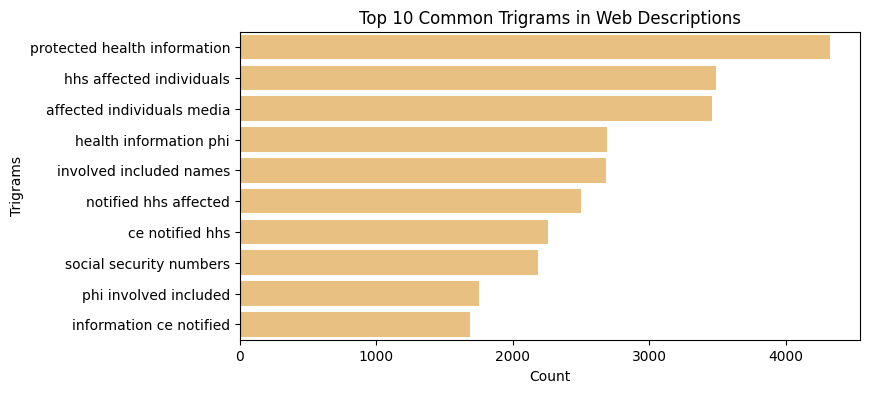

In [ ]:
data['trigrams'] = data['web_description'].apply(lambda x: extract_ngrams(x, 3))
trigrams = [item for sublist in data['trigrams'] for item in sublist]
trigram_freq = FreqDist(trigrams)
df_trigrams = pd.DataFrame(trigram_freq.items(), columns=['phrase', 'count']).sort_values(by='count', ascending=False).head(10)

plt.figure(figsize=(8, 4))
sns.barplot(x='count', y='phrase', data=df_trigrams, color='#F8C471')
plt.title('Top 10 Common Trigrams in Web Descriptions')
plt.xlabel('Count')
plt.ylabel('Trigrams')
plt.show()

## LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
# Calculate the median of 'individuals_affected' and create a binary target variable
median_individuals_affected = data['individuals_affected'].median()
data['incident_severity'] = (data['individuals_affected'] > median_individuals_affected).astype(int)

# Map binary values to 'Major Incident' and 'Minor Incident'
data['incident_severity'] = data['incident_severity'].map({1: 'Major Incident', 0: 'Minor Incident'})

# Prepare text data with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_text = tfidf_vectorizer.fit_transform(data['web_description'])

# Prepare the feature matrix and target vector
X = X_text
y = data['incident_severity']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Evaluate the model
predictions = logistic_model.predict(X_test)
report = classification_report(y_test, predictions)

print(report)


                precision    recall  f1-score   support

Major Incident       0.67      0.66      0.66       795
Minor Incident       0.67      0.68      0.67       816

      accuracy                           0.67      1611
     macro avg       0.67      0.67      0.67      1611
  weighted avg       0.67      0.67      0.67      1611



# NER

In [ ]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 3.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Total number of documents: 930
Document 1:
 - Entity: Bay Oral Surgery & Implant Center, Label: ORG
 - Entity: PHI, Label: ORG
 - Entity: 13,055, Label: CARDINAL
 - Entity: PHI, Label: ORG
 - Entity: Social Security, Label: ORG
 - Entity: HHS, Label: ORG
Document 2:
 - Entity: MHNU Corporation, Label: ORG
 - Entity: Medical Home Network, Label: ORG
 - Entity: PHI, Label: ORG
 - Entity: 681, Label: CARDINAL
 - Entity: PHI, Label: ORG
 - Entity: BA, Label: ORG
 - Entity: HHS, Label: ORG
 - Entity: BA, Label: ORG
 - Entity: PHI, Label: ORG
Document 3:
 - Entity: California Correctional Health Care Services, Label: ORG
 - Entity: one, Label: CARDINAL
 - Entity: PHI, Label: ORG
 - Entity: 1,348, Label: CARDINAL
 - Entity: PHI, Label: ORG
 - Entity: HHS, Label: ORG
 - Entity: PHI, Label: ORG
Document 4:
 - Entity: Massachusetts Department of Developmental Services, Label: ORG
 - Entity: PHI, Label: ORG
 - Entity: 500, Label: CARDINAL
 - Entity: PHI, Label: ORG
 - Entity: Social Security, Lab

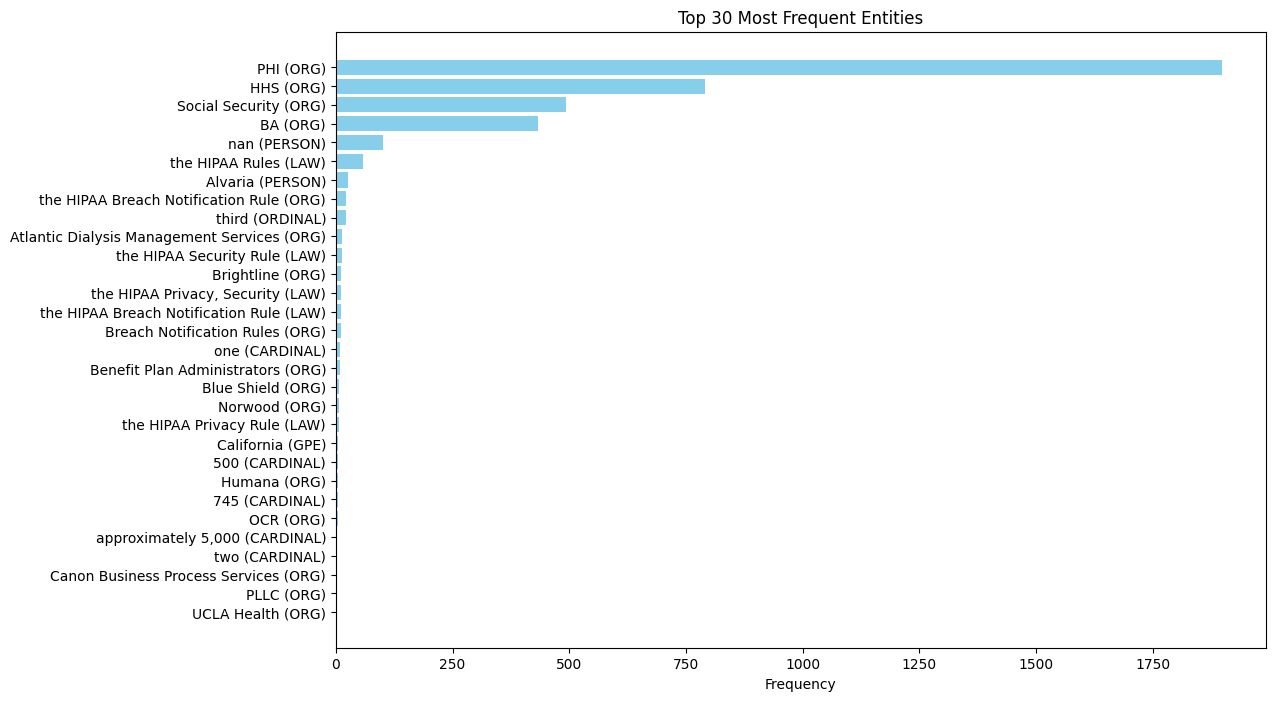

In [40]:
import spacy
import pandas as pd
from spacy.util import minibatch
from spacy import displacy
from collections import Counter
import matplotlib.pyplot as plt

# Load the pre-trained NER model with a larger model
nlp = spacy.load('en_core_web_lg')

# Ensure 'breach_submission_date' is parsed as datetime
data['breach_submission_date'] = pd.to_datetime(data['breach_submission_date'], errors='coerce')

# Filter data for the years 2022, 2023, and 2024
data_filtered = data[data['breach_submission_date'].dt.year.isin([2022, 2023, 2024])]

# Drop rows with invalid dates
data_filtered = data_filtered.dropna(subset=['breach_submission_date'])

# Function to process text in smaller batches
def process_text_in_smaller_batches(texts, batch_size=10):
    entities = []
    for batch in minibatch(texts, size=batch_size):
        docs = nlp.pipe(batch)
        for doc in docs:
            entities.append(doc)
    return entities

# Apply NER to the filtered web descriptions with smaller batch size
docs = process_text_in_smaller_batches(data_filtered['web_description'].fillna('').tolist())

# Check number of documents and entities in a few documents
print(f"Total number of documents: {len(docs)}")


for idx, doc in enumerate(docs[:5]):
    print(f"Document {idx+1}:")
    for ent in doc.ents:
        print(f" - Entity: {ent.text}, Label: {ent.label_}")


total_entities = sum(len(doc.ents) for doc in docs)
print(f"Total number of entities recognized: {total_entities}")


all_entities = [ent for doc in docs for ent in doc.ents]
entity_counter = Counter([(ent.text, ent.label_) for ent in all_entities])


entity_freq_df = pd.DataFrame(entity_counter.items(), columns=['Entity', 'Frequency']).sort_values(by='Frequency', ascending=False)


print(entity_freq_df.head(30))

top_entities = entity_freq_df.head(30)
plt.figure(figsize=(12, 8))
plt.barh(top_entities['Entity'].apply(lambda x: f"{x[0]} ({x[1]})"), top_entities['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 30 Most Frequent Entities')
plt.gca().invert_yaxis()
plt.show()


# LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
# Create a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(data['web_description'])

# Apply LDA to find topics
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(dtm)

# Display the top words in each topic
def display_topics(model, feature_names, num_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topics[f"Topic {topic_idx+1}"] = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
    return topics

num_top_words = 10
feature_names = vectorizer.get_feature_names_out()
topics = display_topics(lda, feature_names, num_top_words)

# Convert topics into a DataFrame
topics_df = pd.DataFrame(topics)

# Display the DataFrame
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,ba,nan,ce,information,health
1,business,case,breach,ce,ocr
2,associate,entity,information,individuals,hipaa
3,individuals,investigation,individuals,affected,security
4,phi,closed,ocr,health,information
5,breach,covered,affected,phi,plan
6,information,review,provided,security,ephi
7,ce,consolidated,health,reported,risk
8,affected,ocr,phi,involved,action
9,health,determined,notification,notified,rules


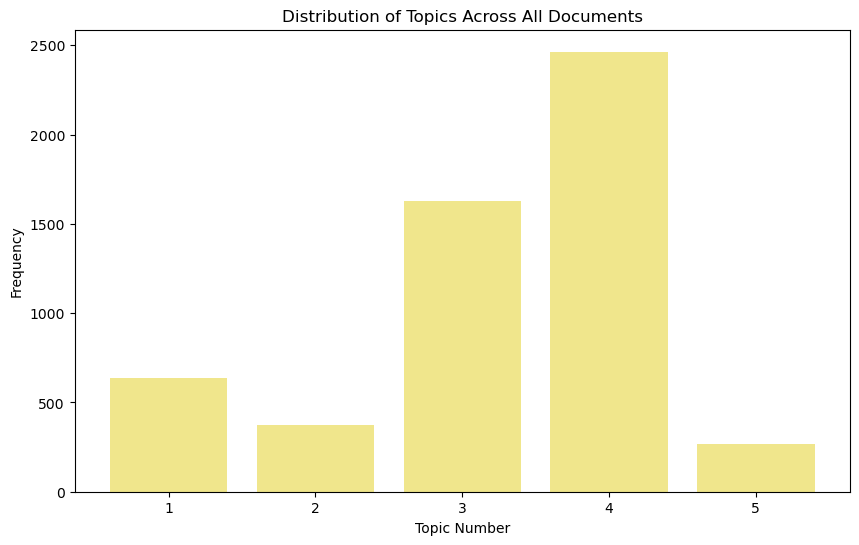

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the topic distribution for each document
topic_distribution = lda.transform(dtm)

# Sum the topic distribution across all documents to get the overall distribution
topic_counts = topic_distribution.sum(axis=0)

# Plot the distribution of topics
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(topic_counts) + 1), topic_counts, color='#F0E68C')
plt.xlabel('Topic Number')
plt.ylabel('Frequency')
plt.title('Distribution of Topics Across All Documents')
plt.xticks(range(1, len(topic_counts) + 1))
plt.show()


In [ ]:
# Get the topic distribution for each document
topic_distribution = lda.transform(dtm)

# Identify the documents with the highest contribution to Topic 2 (index 1, as it is zero-indexed)
topic_4_contributions = topic_distribution[:, 3]
top_topic_4_indices = np.argsort(topic_4_contributions)[-5:]  # Get top 5 documents for Topic 4

# Extract the corresponding descriptions
top_topic_4_descriptions = data.iloc[top_topic_4_indices][['cleaned_description', 'web_description']]
top_topic_4_descriptions


,cleaned_description,web_description
2150,advocate aurora health reported several employ...,", Advocate Aurora Health, reported that severa..."
3061,boy town national research hospital reported e...,", Boys Town National Research Hospital, report..."
2977,boy town national research hospital reported e...,", Boys Town National Research Hospital, report..."
2376,arizona dental insurance service dba delta den...,Arizona Dental Insurance Services dba Delta De...
3224,sinai health system reported several employee ...,", Sinai Health System, reported that several e..."


# BERT

In [ ]:
pip install bertopic

In [ ]:
# Ensure 'breach_submission_date' is parsed as datetime
data['breach_submission_date'] = pd.to_datetime(data['breach_submission_date'], errors='coerce')

# Filter data for the years 2022, 2023, and 2024
data_filtered = data[data['breach_submission_date'].dt.year.isin([2022, 2023, 2024])]

# Initialize BERTopic with calculate_probabilities=True
topic_model = BERTopic(calculate_probabilities=True)

# Fit the model on the 'web_description' column
topics, probs = topic_model.fit_transform(data_filtered['web_description'].fillna('').tolist())

# Get topic information
topic_info = topic_model.get_topic_info()

# Add the cluster labels to the dataframe
data_filtered['Cluster'] = topics

# Display topic information
print(topic_info)

    Topic  Count                                  Name  \
0      -1    121                      -1_the_and_ce_to   
1       0    140                      0_the_ba_and_its   
2       1    108               1_the_and_ransomware_ce   
3       2    107               2_the_ba_and_ransomware   
4       3    100                              3_nan___   
5       4     80               4_email_an_the_phishing   
6       5     60                      5_the_and_phi_ce   
7       6     37                       6_the_to_ce_phi   
8       7     29                        7_an_ba_the_of   
9       8     27      8_impermissibly_the_accessed_and   
10      9     22                 9_mailed_wrong_ba_the   
11     10     22     10_ba_the_identification_provided   
12     11     19            11_the_hipaa_ocr_regarding   
13     12     18                   12_the_an_email_and   
14     13     14     13_alvaria_obligations_protect_on   
15     14     14    14_dialysis_atlantic_ba_management   
16     15     

In [ ]:
# Visualize the topics
fig1 = topic_model.visualize_topics()
fig1.show()

In [ ]:
# Visualize the topic similarity
fig2 = topic_model.visualize_heatmap()
fig2.show()

In [ ]:
# Visualize Topics per Class
topics_per_class = topic_model.topics_per_class(data_filtered['web_description'], topics)
fig3 = topic_model.visualize_topics_per_class(topics_per_class)
fig3.show()

# Methodology: Text Classification

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


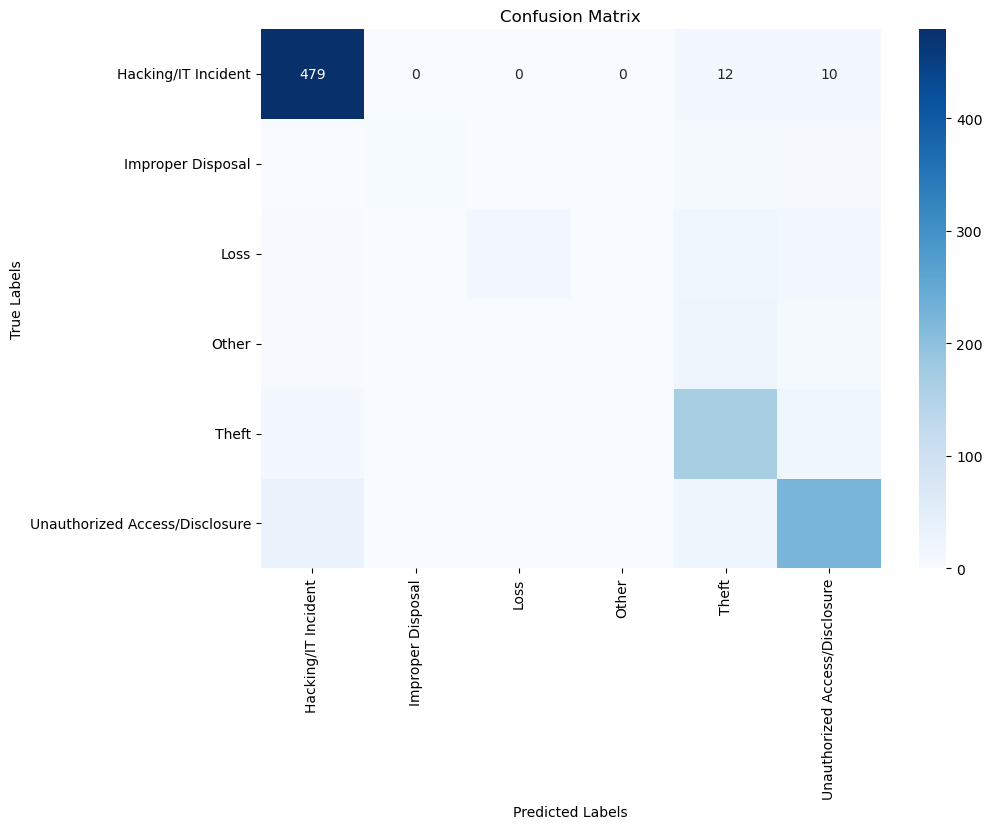

In [ ]:
# Extract relevant columns
descriptions = data['web_description'].astype(str)
labels = data['simplified_type_of_breach']

# Feature extraction: TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = tfidf_vectorizer.fit_transform(descriptions)
y = labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model: Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizing the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Hacking/IT Incident,0.908918,0.956088,0.931907,501.000000
Improper Disposal,0.800000,0.222222,0.347826,18.000000
Loss,1.000000,0.297872,0.459016,47.000000
Other,0.000000,0.000000,0.000000,34.000000
Theft,0.668016,0.846154,0.746606,195.000000
Unauthorized Access/Disclosure,0.797153,0.802867,0.800000,279.000000
accuracy,0.824953,0.824953,0.824953,0.824953
macro avg,0.695681,0.520867,0.547559,1074.000000
weighted avg,0.809532,0.824953,0.804011,1074.000000
